<a href="https://colab.research.google.com/github/mitch222/Predict-Podcast-Competition/blob/main/Predict_Podcast_Listening_Time.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install category_encoders

In [ ]:
from google.colab import files
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
import category_encoders as ce
from lightgbm import LGBMRegressor


Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"mitchellbermin","key":"d819436423503ff3e479d9fe527d5aef"}'}

In [33]:
_ = files.upload()

Saving kaggle.json to kaggle.json


In [ ]:
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle competitions download -c playground-series-s5e4

playground-series-s5e4.zip: Skipping, found more recently modified local copy (use --force to force download)


In [ ]:
!unzip playground-series-s5e4.zip -d ./data

Archive:  playground-series-s5e4.zip
replace ./data/sample_submission.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [ ]:
df_train = pd.read_csv('./data/train.csv')
df_test = pd.read_csv('./data/test.csv')

In [ ]:
df_train.columns

Index(['id', 'Podcast_Name', 'Episode_Title', 'Episode_Length_minutes',
       'Genre', 'Host_Popularity_percentage', 'Publication_Day',
       'Publication_Time', 'Guest_Popularity_percentage', 'Number_of_Ads',
       'Episode_Sentiment', 'Listening_Time_minutes'],
      dtype='object')

In [ ]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 750000 entries, 0 to 749999
Data columns (total 12 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   id                           750000 non-null  int64  
 1   Podcast_Name                 750000 non-null  object 
 2   Episode_Title                750000 non-null  object 
 3   Episode_Length_minutes       750000 non-null  float64
 4   Genre                        750000 non-null  object 
 5   Host_Popularity_percentage   750000 non-null  float64
 6   Publication_Day              750000 non-null  object 
 7   Publication_Time             750000 non-null  object 
 8   Guest_Popularity_percentage  750000 non-null  float64
 9   Number_of_Ads                750000 non-null  float64
 10  Episode_Sentiment            750000 non-null  object 
 11  Listening_Time_minutes       750000 non-null  float64
dtypes: float64(5), int64(1), object(6)
memory usage: 68.7+ MB


In [ ]:
df_train.head()

,id,Podcast_Name,Episode_Title,Episode_Length_minutes,Genre,Host_Popularity_percentage,Publication_Day,Publication_Time,Guest_Popularity_percentage,Number_of_Ads,Episode_Sentiment,Listening_Time_minutes
0,0,Mystery Matters,Episode 98,NaN,True Crime,74.81,Thursday,Night,NaN,0.0,Positive,31.41998
1,1,Joke Junction,Episode 26,119.80,Comedy,66.95,Saturday,Afternoon,75.95,2.0,Negative,88.01241
2,2,Study Sessions,Episode 16,73.90,Education,69.97,Tuesday,Evening,8.97,0.0,Negative,44.92531
3,3,Digital Digest,Episode 45,67.17,Technology,57.22,Monday,Morning,78.70,2.0,Positive,46.27824
4,4,Mind & Body,Episode 86,110.51,Health,80.07,Monday,Afternoon,58.68,3.0,Neutral,75.61031


In [ ]:
# Check for missing values in the training dataset
missing_values_train = df_train.isnull().sum()
print("Missing values in the training dataset:\n", missing_values_train)

# Check for missing values in the test dataset
missing_values_test = df_test.isnull().sum()
print("\nMissing values in the test dataset:\n", missing_values_test)


Missing values in the training dataset:
 id                                  0
Podcast_Name                        0
Episode_Title                       0
Episode_Length_minutes          87093
Genre                               0
Host_Popularity_percentage          0
Publication_Day                     0
Publication_Time                    0
Guest_Popularity_percentage    146030
Number_of_Ads                       1
Episode_Sentiment                   0
Listening_Time_minutes              0
dtype: int64

Missing values in the test dataset:
 id                                 0
Podcast_Name                       0
Episode_Title                      0
Episode_Length_minutes         28736
Genre                              0
Host_Popularity_percentage         0
Publication_Day                    0
Publication_Time                   0
Guest_Popularity_percentage    48832
Number_of_Ads                      0
Episode_Sentiment                  0
dtype: int64


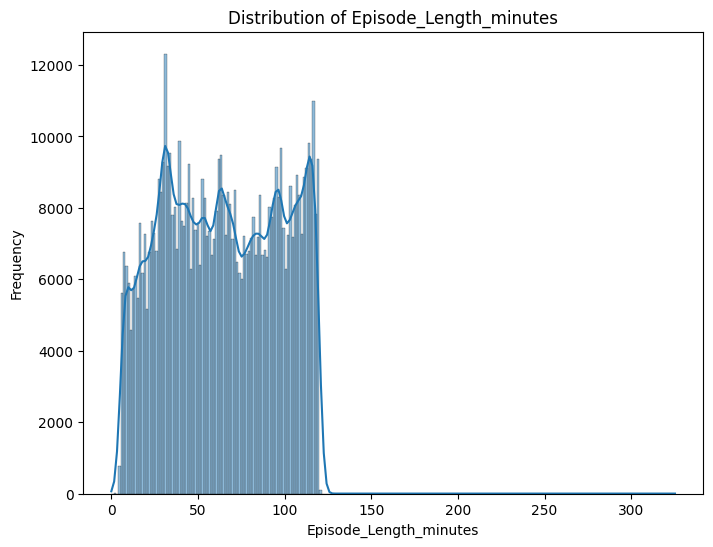

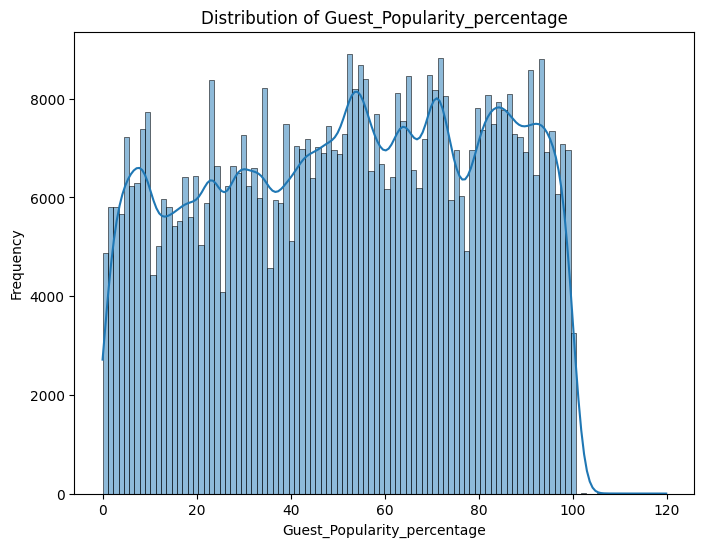

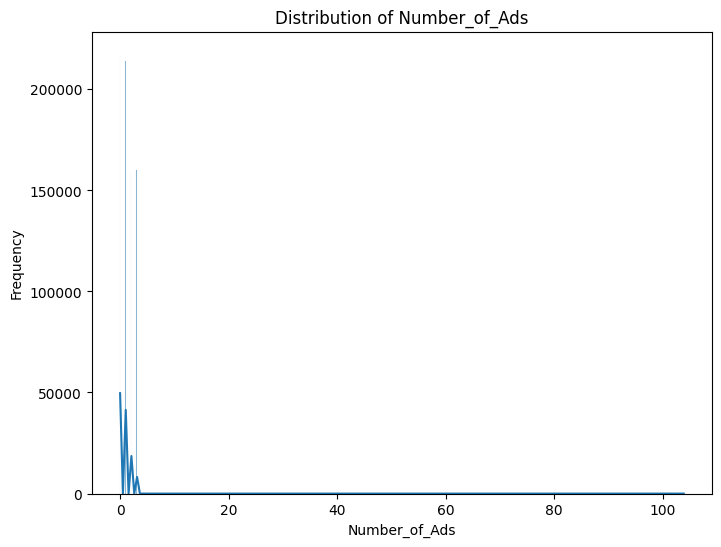

In [ ]:
# Select numeric columns for the histogram
numeric_cols= df_train.select_dtypes(include=np.number)

numerics_with_nulls = numeric_cols.loc[:, numeric_cols.isnull().any()]

# Create histograms for each numeric column
for col in numerics_with_nulls:
    plt.figure(figsize=(8, 6))  # Adjust figure size as needed
    sns.histplot(df_train[col], kde=True)  # Use seaborn for better aesthetics
    plt.title(f'Distribution of {col}')
    plt.xlabel(col)
    plt.ylabel('Frequency')
    plt.show()


In [ ]:
df_train = df_train.fillna(df_train.mean(numeric_only=True))
df_test = df_test.fillna(df_train.mean(numeric_only=True))

In [ ]:
# Check for missing values in the training dataset
missing_values_train = df_train.isnull().sum()
print("Missing values in the training dataset:\n", missing_values_train)

# Check for missing values in the test dataset
missing_values_test = df_test.isnull().sum()
print("\nMissing values in the test dataset:\n", missing_values_test)


Missing values in the training dataset:
 id                             0
Podcast_Name                   0
Episode_Title                  0
Episode_Length_minutes         0
Genre                          0
Host_Popularity_percentage     0
Publication_Day                0
Publication_Time               0
Guest_Popularity_percentage    0
Number_of_Ads                  0
Episode_Sentiment              0
Listening_Time_minutes         0
dtype: int64

Missing values in the test dataset:
 id                             0
Podcast_Name                   0
Episode_Title                  0
Episode_Length_minutes         0
Genre                          0
Host_Popularity_percentage     0
Publication_Day                0
Publication_Time               0
Guest_Popularity_percentage    0
Number_of_Ads                  0
Episode_Sentiment              0
dtype: int64


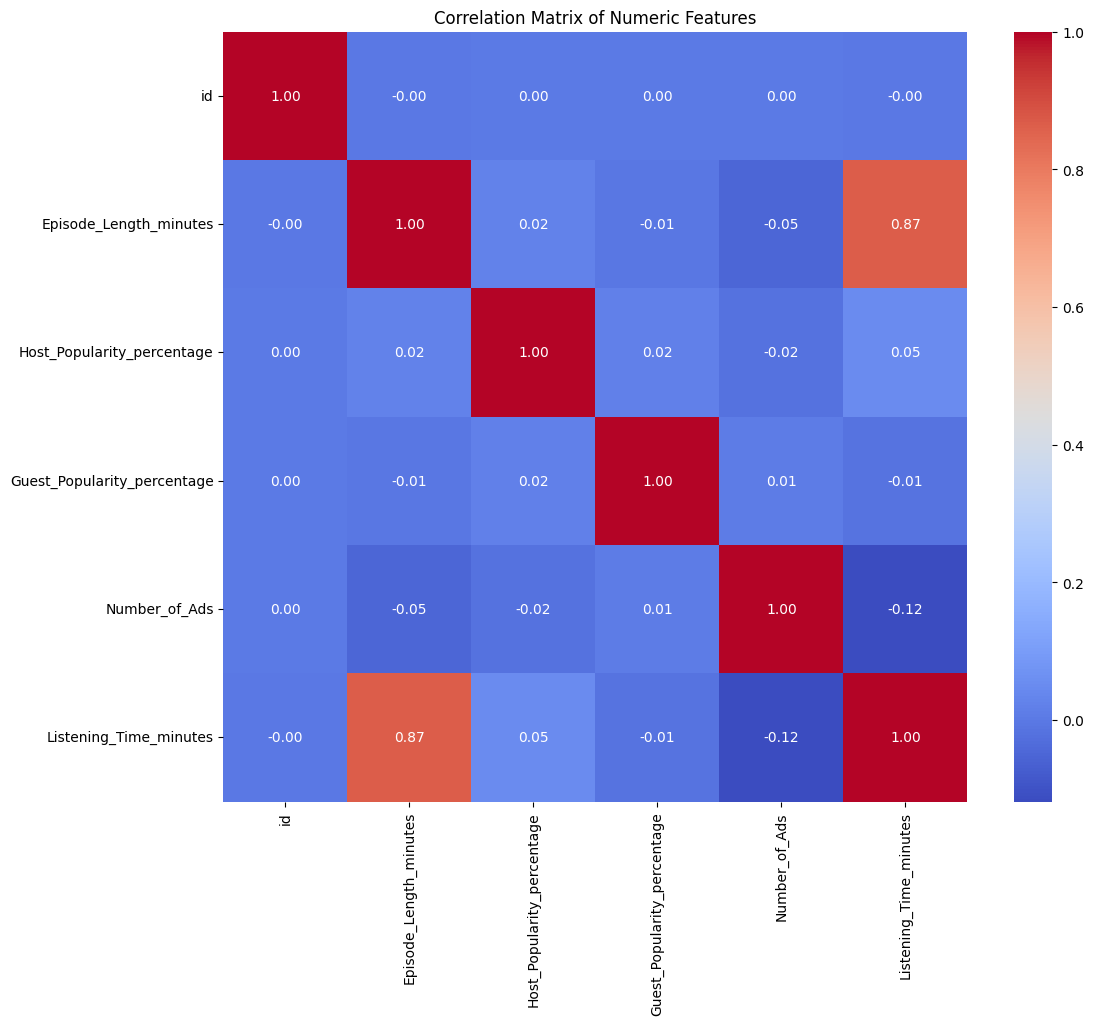

In [ ]:
# Calculate the correlation matrix for numeric columns
correlation_matrix = df_train.select_dtypes(include=np.number).corr()

# Create a heatmap of the correlation matrix
plt.figure(figsize=(12, 10))  # Adjust figure size as needed
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix of Numeric Features')
plt.show()


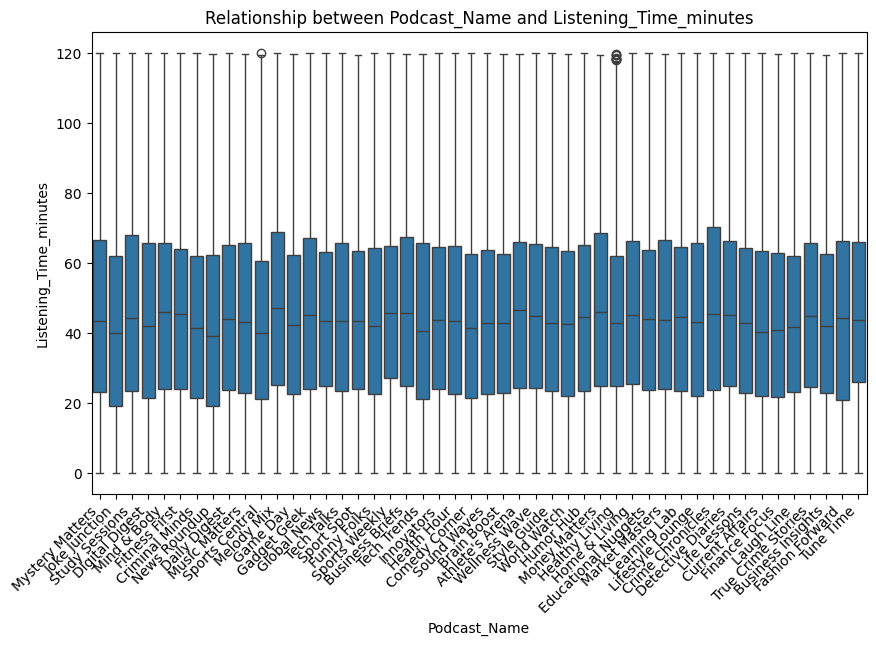

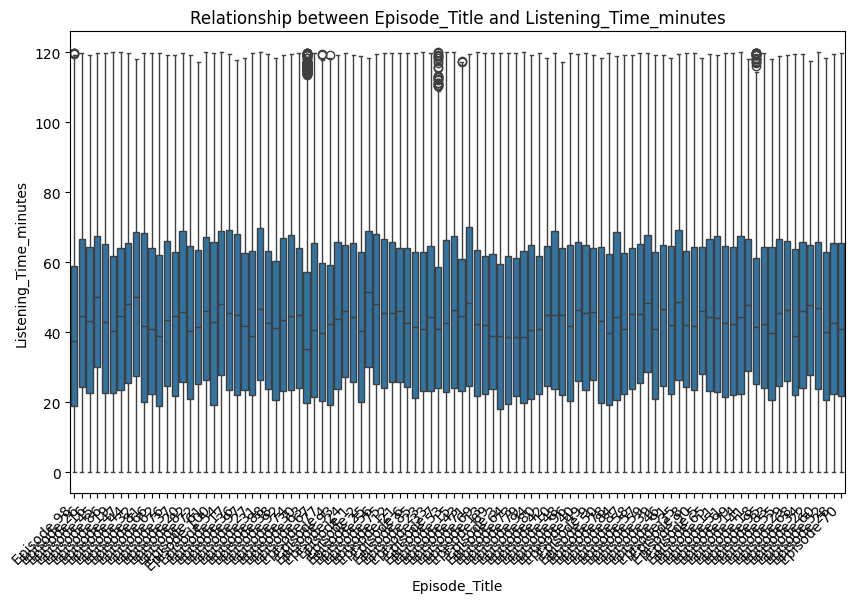

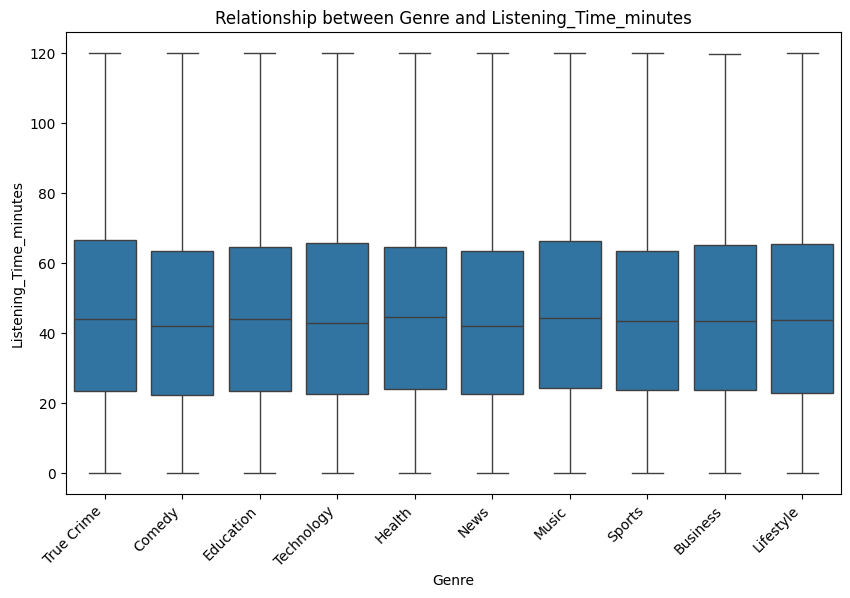

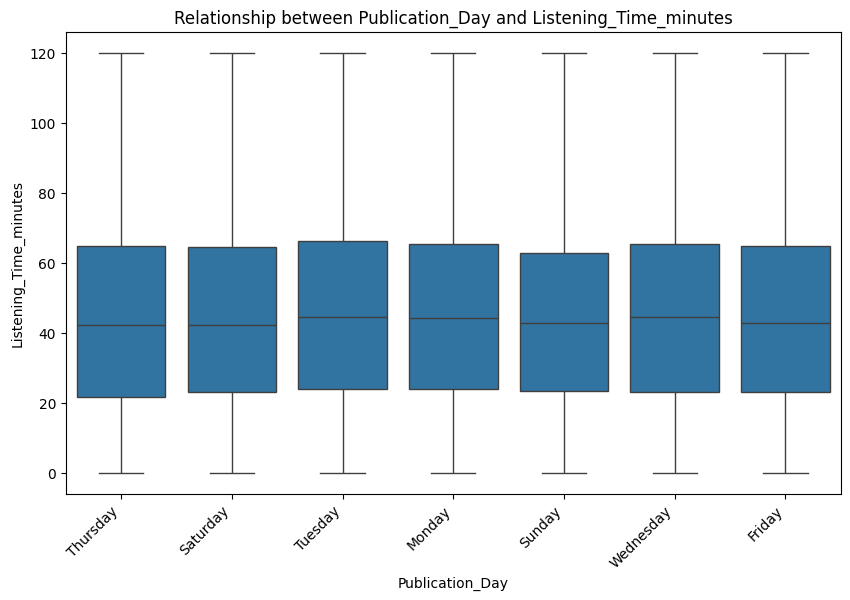

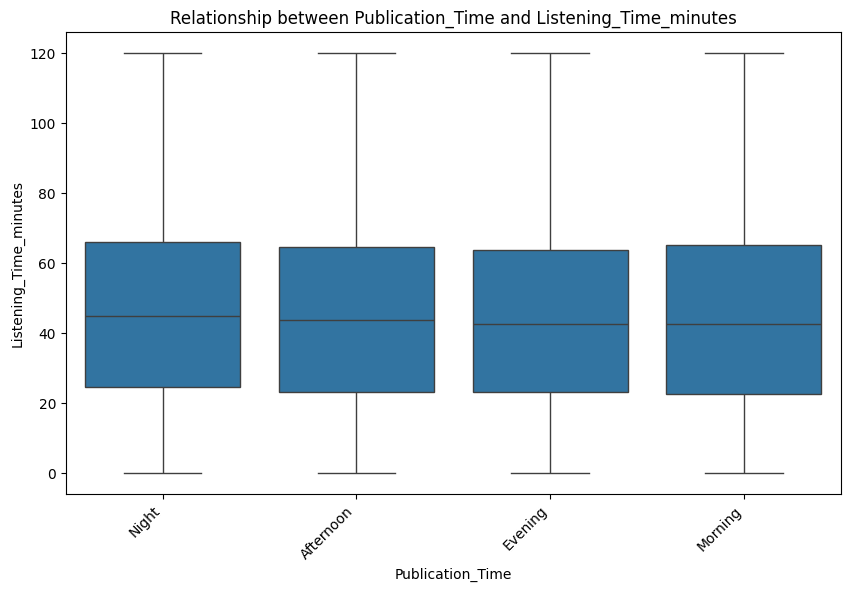

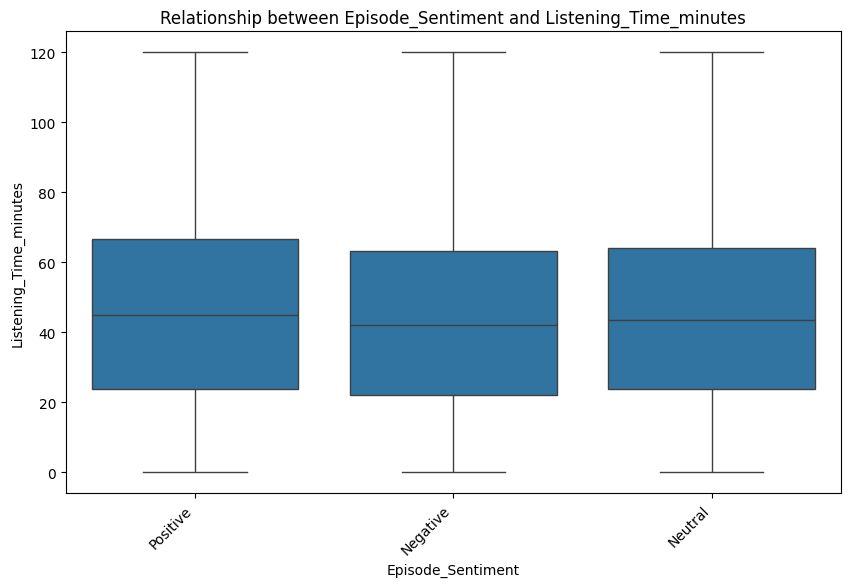

In [ ]:
# Identify non-numeric columns
non_numeric_cols = df_train.select_dtypes(exclude=np.number).columns

# Create box plots for each non-numeric column against Listening_Time_minutes
for col in non_numeric_cols:
    plt.figure(figsize=(10, 6))
    sns.boxplot(x=col, y='Listening_Time_minutes', data=df_train)
    plt.title(f'Relationship between {col} and Listening_Time_minutes')
    plt.xlabel(col)
    plt.ylabel('Listening_Time_minutes')
    plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability
    plt.show()


In [ ]:
# Columnas
onehot_cols = ['Genre', 'Publication_Day', 'Publication_Time']
target_encoded_cols = ['Podcast_Name', 'Episode_Title']
target_var = 'Listening_Time_minutes'

# Separar data
X_train = df_train.drop(columns=[target_var])
y_train = df_train[target_var]
X_test = df_test.copy()

# OneHot y TargetEncoder
onehot_encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
target_encoder = ce.TargetEncoder()

preprocessor = ColumnTransformer([
    ('ohe', onehot_encoder, onehot_cols)
], remainder='drop')

# Transformación
X_train_ohe = preprocessor.fit_transform(X_train)
X_test_ohe = preprocessor.transform(X_test)

X_train_target = target_encoder.fit_transform(X_train[target_encoded_cols], y_train)
X_test_target = target_encoder.transform(X_test[target_encoded_cols])

# Concatenar
X_train_final = np.hstack([X_train_ohe, X_train_target])
X_test_final = np.hstack([X_test_ohe, X_test_target])


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.013060 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 192
[LightGBM] [Info] Number of data points in the train set: 750000, number of used features: 23
[LightGBM] [Info] Start training from score 45.437406


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


In [32]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform, randint

param_dist = {
    'n_estimators': randint(100, 600),
    'learning_rate': uniform(0.001, 0.1),
    'num_leaves': randint(20, 100),
    'subsample': uniform(0.9, 0.1),
    'colsample_bytree': uniform(0.9, 0.1)
}

random_search = RandomizedSearchCV(
    estimator=LGBMRegressor(random_state=42),
    param_distributions=param_dist,
    scoring='neg_root_mean_squared_error',
    n_iter=35,  # puedes aumentar esto para más precisión
    cv=3,
    verbose=1,
    n_jobs=-1
)

random_search.fit(X_train_final, y_train)

print("Mejores parámetros:", random_search.best_params_)
print("RMSE:", -random_search.best_score_)

Fitting 3 folds for each of 35 candidates, totalling 105 fits


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.013750 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 192
[LightGBM] [Info] Number of data points in the train set: 750000, number of used features: 23
[LightGBM] [Info] Start training from score 45.437406
Mejores parámetros: {'colsample_bytree': np.float64(0.9159939595952762), 'learning_rate': np.float64(0.06484197678781695), 'n_estimators': 382, 'num_leaves': 89, 'subsample': np.float64(0.9254743368952218)}
RMSE: 26.978438463890473


In [ ]:
# Los mejores hiperparámetros:
best_params = random_search.best_params_

final_model = LGBMRegressor(**best_params, random_state=42)
final_model.fit(X_train_final, y_train)

# Predicción
y_pred = final_model.predict(X_test_final)
df_test['Predicted_Listening_Time'] = y_pred

# Guardar resultados
df_test[['id', 'Predicted_Listening_Time']].to_csv('lightgbm_predicciones.csv', index=False)

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.039874 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 192
[LightGBM] [Info] Number of data points in the train set: 750000, number of used features: 23
[LightGBM] [Info] Start training from score 45.437406


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
